# Image Classification of the Oxford Flowers 102 dataset

In this project, we'll train an image classifier to recognize different species of flowers. In practice we'd train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, a few examples below:

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.

Here our network will be learning about flowers and end up with a script that will serve as a command line application. 

## Import Resources

In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

tfds.disable_progress_bar()

In [2]:
# Make all other necessary imports.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import json

### Print out the versions of the libs being used

In [3]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)

Using:
	• TensorFlow version: 2.6.0
	• tf.keras version: 2.6.0


## Load the Dataset

Here we'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  We'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the MobileNet pre-trained network that we will use later.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but we'll still need to normalize and resize the images to the appropriate size for inference.

In [4]:
# Download data to default local directory "~/tensorflow_datasets"
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# Load the dataset with TensorFlow Datasets. Use tfds.load()

dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [5]:
# Create a training set, a validation set and a test set.

# Since the size of the test set is larger than the training, we have mapped the test_set to be used for model 
# training and the training_set be used for evaluation

training_set = dataset['test']
validation_set = dataset['validation']
test_set = dataset['train']

## Explore the Dataset

In [6]:
# Get the number of examples in each set from the dataset info.

num_training = dataset_info.splits['test'].num_examples
num_validation = dataset_info.splits['validation'].num_examples
num_test = dataset_info.splits['train'].num_examples

print('Number of training examples: ', num_training)
print('Number of validation examples: ', num_validation)
print('Number of testing examples: ', num_test)


# Get the number of classes in the dataset from the dataset info.

num_classes = dataset_info.features['label'].num_classes
print('Number of Classes: ', num_classes)

Number of training examples:  6149
Number of validation examples:  1020
Number of testing examples:  1020
Number of Classes:  102


In [7]:
# Print the shape and corresponding label of 3 images in the training set.

i = 0
for image, label in training_set.take(3):
    print('Shape of Image ', i + 1, '::')
    print(image.numpy().shape)
    print('Label: ', label.numpy())
    print('\n')
    i += 1

Shape of Image  1 ::
(542, 500, 3)
Label:  40


Shape of Image  2 ::
(748, 500, 3)
Label:  76


Shape of Image  3 ::
(500, 600, 3)
Label:  42




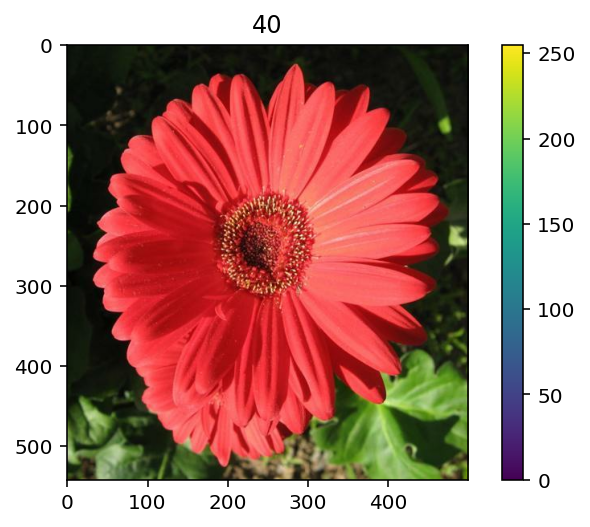

In [8]:
# Plot 1 image from the training set. Set the title of the plot to the corresponding image label.

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image)
plt.colorbar()
plt.title(label)
plt.show()

### Label Mapping

We'll need to load in a mapping from label to category name. We can find this in the file `label_map.json` that comes along with the dataset. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give us a dictionary mapping the integer coded labels to the actual names of the flowers.

In [9]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)
    
class_names

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [10]:
# Normalize the images to proper sizes

def image_normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.image.resize(image, [224, 224])
    return image, label

training_set = training_set.map(image_normalize)
validation_set = validation_set.map(image_normalize)
test_set = test_set.map(image_normalize)

training_set, validation_set, test_set

(<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>)

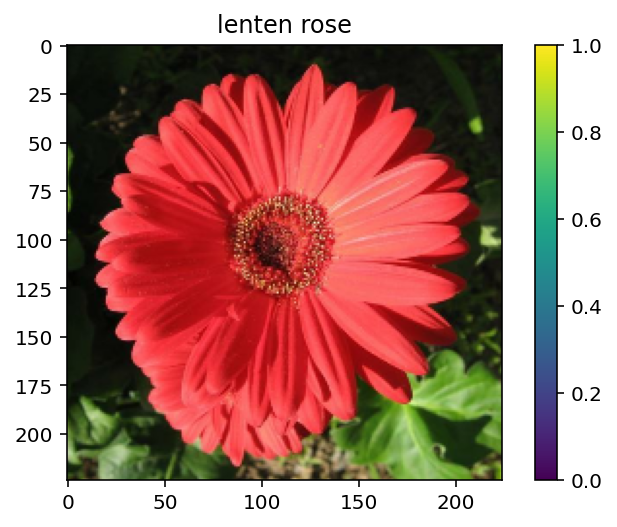

In [11]:
# Plot 1 image from the training set. Set the title of the plot to the 
# corresponding class name. 

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image)
plt.colorbar()
plt.title(class_names[str(label)])
plt.show()

## Create Pipeline

In [12]:
# Create a pipeline for each set.

batch_size = 51

training_batches = training_set.cache().shuffle(num_training // 4).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. We wil be comparing the performances of different networks employed here :-
 - First, we will build and train a custom ANN model, evaluate its performance on the validation and testing sets.
 - Next, we will build and train a custom CNN model, evaluate its performance on the validation and testing sets.
 - Finally, we will use the pre-trained MobileNet model, train it and evaluate its performance on the validation and testing sets.
 - We will save the best performing model and reload the same to make predictions.

## 1. Build and Train an ANN model first, evaluate the Accuracy

In [13]:
# Build the ANN model.

tf.keras.backend.clear_session()

ann_classifier = tf.keras.models.Sequential([
                                            tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
                                            tf.keras.layers.Dense(1024, activation = 'relu'),
                                            tf.keras.layers.Dropout(0.3),
                                            tf.keras.layers.Dense(512, activation = 'relu'),
                                            tf.keras.layers.Dropout(0.3),
                                            tf.keras.layers.Dense(256, activation = 'relu'),
                                            tf.keras.layers.Dropout(0.3),
                                            tf.keras.layers.Dense(128, activation = 'relu'),
                                            tf.keras.layers.Dropout(0.3),
                                            tf.keras.layers.Dense(102, activation = 'softmax')
])

ann_classifier.compile(optimizer = 'adam',
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

ann_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              154141696 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [14]:
# Evaluate the accuracy and loss of untrained model

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = ann_classifier.evaluate(image_batch, label_batch)

print('Loss of the untrained model: ', loss * 100)
print('Accuracy of the untrained model: ', accuracy * 100)

2/2 [==============================] - 1s 180ms/step - loss: 4.5725 - accuracy: 0.0196
Loss of the untrained model:  457.24620819091797
Accuracy of the untrained model:  1.9607843831181526


In [15]:
# Train the model

num_epochs = 30
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

history = ann_classifier.fit(training_batches,
                             epochs = num_epochs,
                             validation_data = validation_batches,
                             callbacks = [early_stopping])

Epoch 1/30
121/121 [==============================] - 141s 1s/step - loss: 8.9434 - accuracy: 0.0159 - val_loss: 4.6238 - val_accuracy: 0.0069
Epoch 2/30
121/121 [==============================] - 120s 992ms/step - loss: 4.5659 - accuracy: 0.0288 - val_loss: 4.6192 - val_accuracy: 0.0088
Epoch 3/30
121/121 [==============================] - 121s 997ms/step - loss: 4.5198 - accuracy: 0.0356 - val_loss: 4.6463 - val_accuracy: 0.0098
Epoch 4/30
121/121 [==============================] - 121s 999ms/step - loss: 4.4760 - accuracy: 0.0407 - val_loss: 4.6815 - val_accuracy: 0.0118
Epoch 5/30
121/121 [==============================] - 119s 988ms/step - loss: 4.4449 - accuracy: 0.0392 - val_loss: 4.7596 - val_accuracy: 0.0098
Epoch 6/30
121/121 [==============================] - 120s 992ms/step - loss: 4.4361 - accuracy: 0.0394 - val_loss: 4.7697 - val_accuracy: 0.0078
Epoch 7/30
121/121 [==============================] - 120s 996ms/step - loss: 4.4326 - accuracy: 0.0400 - val_loss: 4.7735 - va

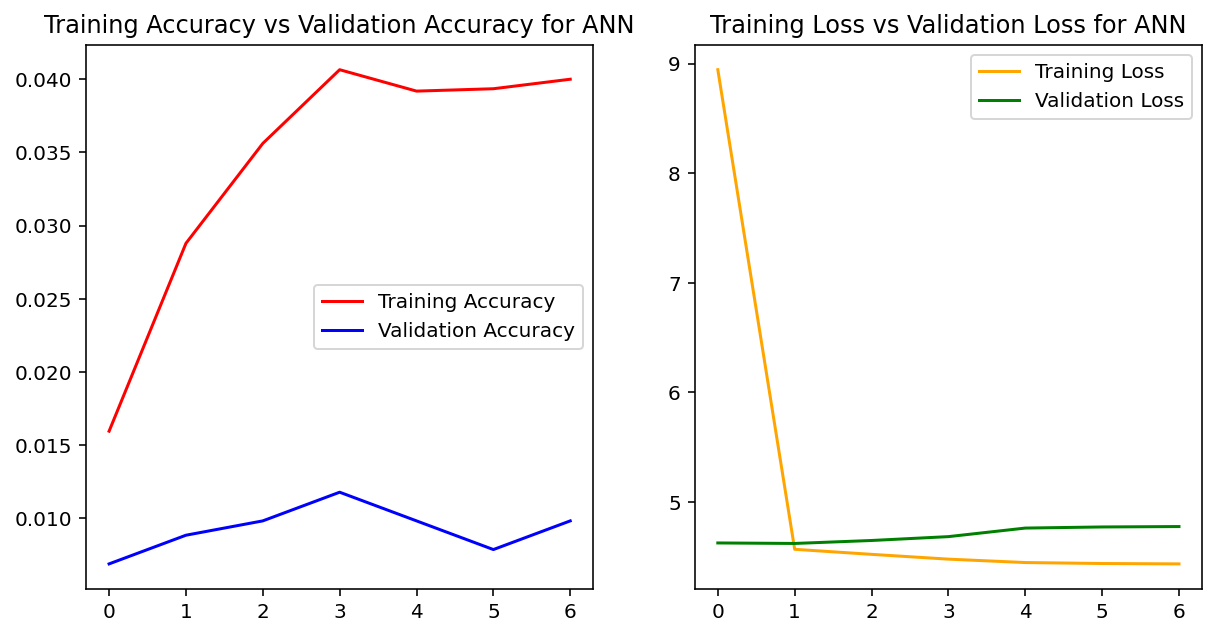

In [16]:
# extract the training accuracy,loss & validation accuracy, loss to be plotted.

train_acc, train_loss, val_accuracy, val_loss = history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']

# Plot the validation loss with train loss and similar with accuracy for this ANN model

epochs_range = range(len(train_acc))

plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, color = 'red', label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, color = 'blue', label = 'Validation Accuracy')
plt.legend(loc = 'middle right')
plt.title('Training Accuracy vs Validation Accuracy for ANN')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, color = 'orange', label = 'Training Loss')
plt.plot(epochs_range, val_loss, color = 'green', label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training Loss vs Validation Loss for ANN')

plt.show()

## 2. Now build and train a CNN model and plot the same Accuracy & Loss for Train & Validation batches for comparison.

In [17]:
# Build the CNN model

tf.keras.backend.clear_session()

cnn_classifier = tf.keras.models.Sequential([
                            # Image preprocessing layers

                            tf.keras.layers.RandomFlip('vertical', input_shape = (224, 224, 3)),
                            tf.keras.layers.RandomFlip('horizontal'),
                            tf.keras.layers.RandomRotation(factor = 0.2, fill_mode = 'nearest'),
                            tf.keras.layers.RandomZoom(0.3),
                            tf.keras.layers.RandomContrast(0.3),

                            # Convolutional layers
                            
                            tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'),
                            tf.keras.layers.MaxPool2D(),

                            tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
                            tf.keras.layers.MaxPool2D(),

                            tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'),
                            tf.keras.layers.MaxPool2D(),

                            tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu'),
                            tf.keras.layers.MaxPool2D(),

                            # Dense layers
                            
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(1024, activation = 'relu'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(512, activation = 'relu'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(256, activation = 'relu'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(128, activation = 'relu'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(102, activation = 'softmax')
])

cnn_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0

In [18]:
# Compile the CNN model

cnn_classifier.compile(optimizer = 'adam',
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

In [19]:
# Evaluate the accuracy and loss of untrained model

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = cnn_classifier.evaluate(image_batch, label_batch)

print('Loss of the untrained model: ', loss * 100)
print('Accuracy of the untrained model: ', accuracy * 100)

2/2 [==============================] - 30s 513ms/step - loss: 4.6239 - accuracy: 0.0000e+00
Loss of the untrained model:  462.39452362060547
Accuracy of the untrained model:  0.0


In [20]:
# Train the CNN classifier

num_epochs = 500

history = cnn_classifier.fit_generator(training_batches,
                                       epochs = num_epochs,
                                       validation_data = validation_batches)

Epoch 1/500
121/121 [==============================] - 44s 280ms/step - loss: 4.5200 - accuracy: 0.0342 - val_loss: 4.7504 - val_accuracy: 0.0098
Epoch 2/500
121/121 [==============================] - 24s 197ms/step - loss: 4.3717 - accuracy: 0.0504 - val_loss: 4.5646 - val_accuracy: 0.0235
Epoch 3/500
121/121 [==============================] - 24s 196ms/step - loss: 4.1376 - accuracy: 0.0603 - val_loss: 4.3524 - val_accuracy: 0.0206
Epoch 4/500
121/121 [==============================] - 24s 196ms/step - loss: 3.9827 - accuracy: 0.0722 - val_loss: 4.3236 - val_accuracy: 0.0353
Epoch 5/500
121/121 [==============================] - 24s 196ms/step - loss: 3.8633 - accuracy: 0.0846 - val_loss: 4.0489 - val_accuracy: 0.0373
Epoch 6/500
121/121 [==============================] - 24s 195ms/step - loss: 3.7663 - accuracy: 0.0968 - val_loss: 3.9858 - val_accuracy: 0.0490
Epoch 7/500
121/121 [==============================] - 24s 195ms/step - loss: 3.6620 - accuracy: 0.1051 - val_loss: 3.8737 -

In [21]:
# extract the training accuracy,loss & validation accuracy, loss to be plotted for the CNN model.

train_acc, train_loss, val_accuracy, val_loss = history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']

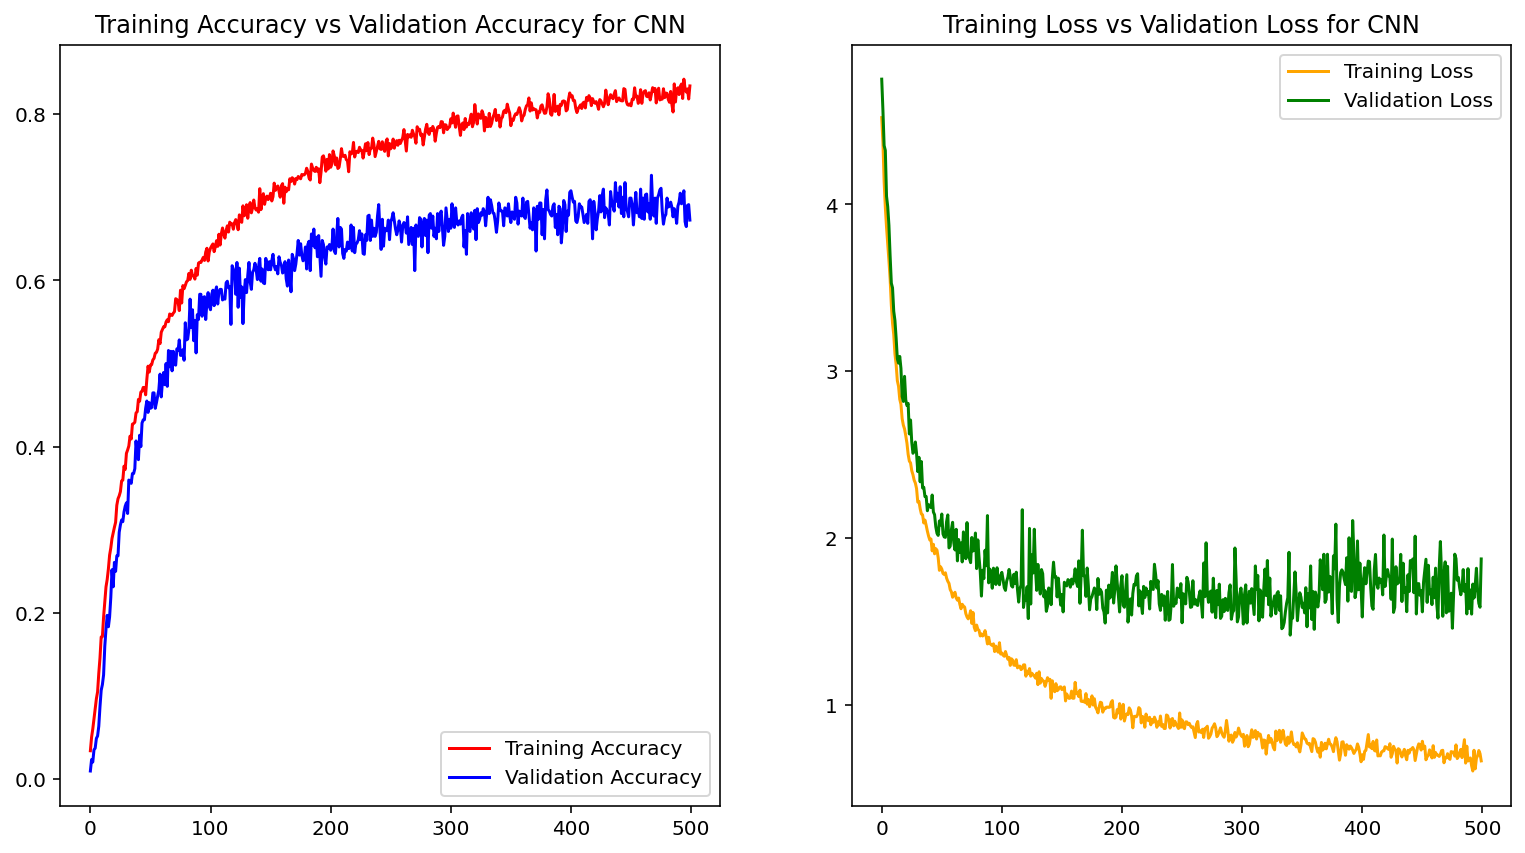

In [22]:
# Plot the validation loss with train loss and similar with accuracy for this CNN model

epochs_range = range(len(train_acc))

plt.figure(figsize = [13, 7])

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, color = 'red', label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, color = 'blue', label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training Accuracy vs Validation Accuracy for CNN')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, color = 'orange', label = 'Training Loss')
plt.plot(epochs_range, val_loss, color = 'green', label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training Loss vs Validation Loss for CNN')

plt.show()

In [24]:
# Evaluate the accuracy and loss of the trained CNN model on the testing batches

loss, accuracy = cnn_classifier.evaluate(testing_batches)

print('Loss of the trained CNN model: ', loss * 100)
print('Accuracy of the trained CNN model: ', accuracy * 100)

20/20 [==============================] - 1s 65ms/step - loss: 1.8724 - accuracy: 0.6990
Loss of the trained CNN model:  187.2417449951172
Accuracy of the trained CNN model:  69.90196108818054


## 3. Now build and train the pretrained MobileNet model and plot the same Accuracy & Loss for Train & Validation batches for comparison. If better than the others, use the same model to predict and evaluate the Test batches.

In [20]:
# Download the MobileNet model and wrap it onto a Keras layer

URL_ = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

feature_extractor = hub.KerasLayer(URL_, input_shape = (224, 224, 3))
feature_extractor.trainable = False

In [21]:
# Build and compile the network

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
# Train the Network

history = model.fit(training_batches,
                    epochs = 10,
                    validation_data = validation_batches)

Epoch 1/10
121/121 [==============================] - 131s 1s/step - loss: 2.2590 - accuracy: 0.5253 - val_loss: 1.2470 - val_accuracy: 0.7333
Epoch 2/10
121/121 [==============================] - 127s 1s/step - loss: 0.6822 - accuracy: 0.8784 - val_loss: 0.7587 - val_accuracy: 0.8422
Epoch 3/10
121/121 [==============================] - 126s 1s/step - loss: 0.3996 - accuracy: 0.9345 - val_loss: 0.6131 - val_accuracy: 0.8627
Epoch 4/10
121/121 [==============================] - 126s 1s/step - loss: 0.2721 - accuracy: 0.9629 - val_loss: 0.5298 - val_accuracy: 0.8784
Epoch 5/10
121/121 [==============================] - 126s 1s/step - loss: 0.2006 - accuracy: 0.9753 - val_loss: 0.4791 - val_accuracy: 0.8833
Epoch 6/10
121/121 [==============================] - 127s 1s/step - loss: 0.1546 - accuracy: 0.9841 - val_loss: 0.4442 - val_accuracy: 0.8951
Epoch 7/10
121/121 [==============================] - 128s 1s/step - loss: 0.1217 - accuracy: 0.9912 - val_loss: 0.4299 - val_accuracy: 0.8951

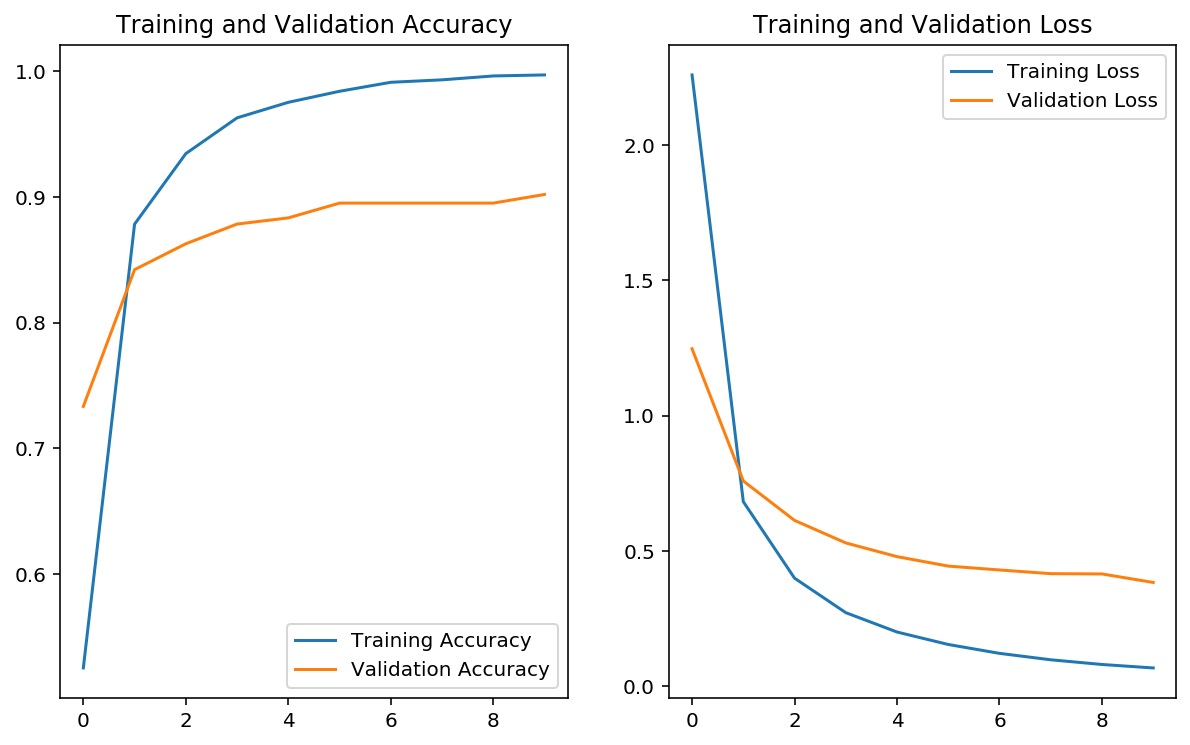

In [23]:
# Plot the loss and accuracy values achieved during training for the training 
# and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Testing the Network

In [24]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print('Loss of the model on testing set: ', loss * 100)
print('Accuracy of model on testing set: ', accuracy * 100)

20/20 [==============================] - 20s 1s/step - loss: 0.4420 - accuracy: 0.8755
Loss of the model on testing set:  44.20428276062012
Accuracy of model on testing set:  87.54901885986328


## Save the Model

We will now save the model so we can load it later for making inference. We will save our model as a Keras 'HD5' model file.

In [25]:
# Save the trained model as a Keras model.

saved_keras_model_filepath = './Oxford_Flowers102_model_MobileNet.h5'

model.save(saved_keras_model_filepath)

## Load the Keras Model

Load the Keras model we saved above.

In [26]:
# Load the Keras model

reloaded_model = tf.keras.models.load_model(saved_keras_model_filepath, 
                                            custom_objects = {'KerasLayer': hub.KerasLayer})

reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now we'll write a function that uses our trained network for inference. A function called `predict` that takes in an image, a model, and then returns the top $K$ most likely class labels along with their probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Our `predict` function should use `PIL` to load the image from the given `image_path`. We will use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. We can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by our model.  

### Image Pre-processing

We will create a `process_image` function, that should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, we should convert our image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, we'll also need to normalize the pixel values. 

Finally, we will convert our image back to a NumPy array using the `.numpy()` method.

In [1]:
# Create the process_image function

def process_image(image_array):
    image_tensor = tf.convert_to_tensor(np.array(image_array))
    image_tensor = tf.cast(image_tensor, tf.float32)
    image_tensor /= 255
    image_tensor = tf.image.resize(image_tensor, [224, 224])
    return image_tensor.numpy()
    

### Testing our `process_image` function:

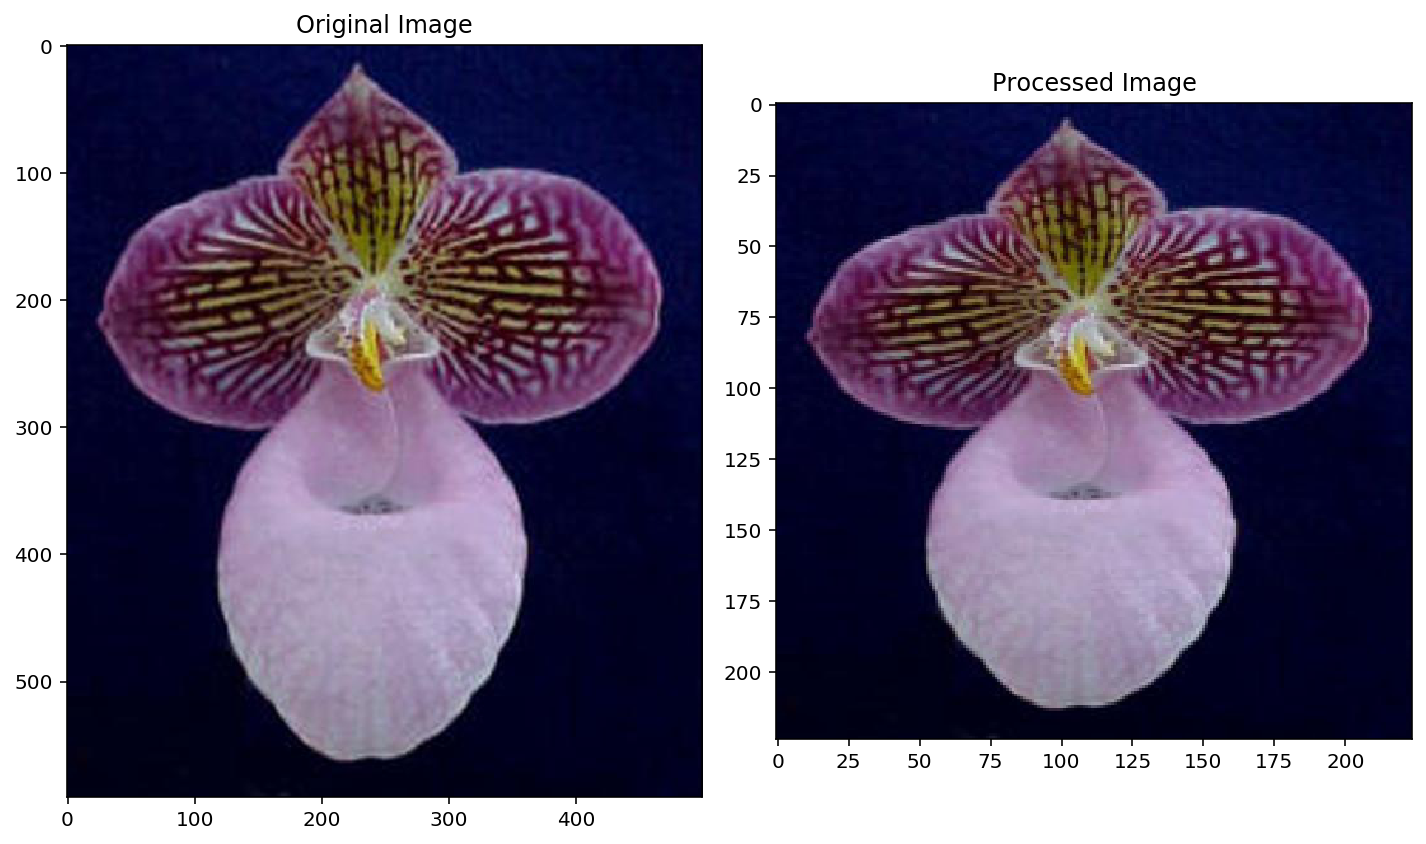

In [7]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

## Inference

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We will use the `np.expand_dims()` function to add the extra dimension. 

In [22]:
# Create the predict function

def predict(image_path, model, top_k):
    from PIL import Image
    
    img = Image.open(image_path)
    test_image = np.asarray(img)
    
    processed_image = process_image(test_image)
    processed_image = np.expand_dims(processed_image, axis = 0)
    
    reloaded_model = tf.keras.models.load_model(model, 
                                                custom_objects = {'KerasLayer': hub.KerasLayer})
    
    img_prob = reloaded_model.predict(processed_image)
    
    return -np.sort(-img_prob)[:, :int(top_k)], np.argsort(-img_prob)[:, :int(top_k)]
    

# Sanity Check

It's always good to check the predictions made by our model to make sure they are correct. To check our predictions we have 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cells below we will use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by our model. We will plot the probabilities as a bar graph.  

Text(0.5, 1.0, 'Class Proability Distribution')

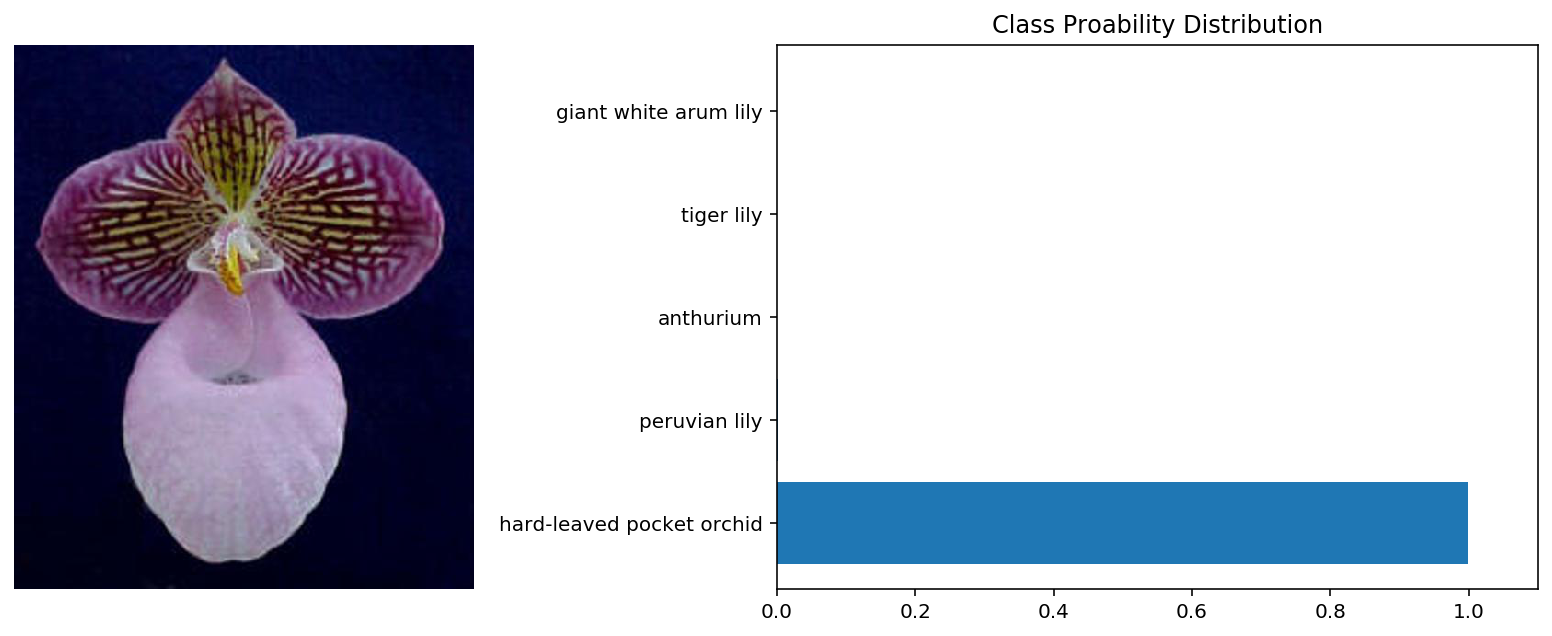

In [43]:
# Plot the input image along with the top 5 classes

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path, 
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

Text(0.5, 1.0, 'Class Proability Distribution')

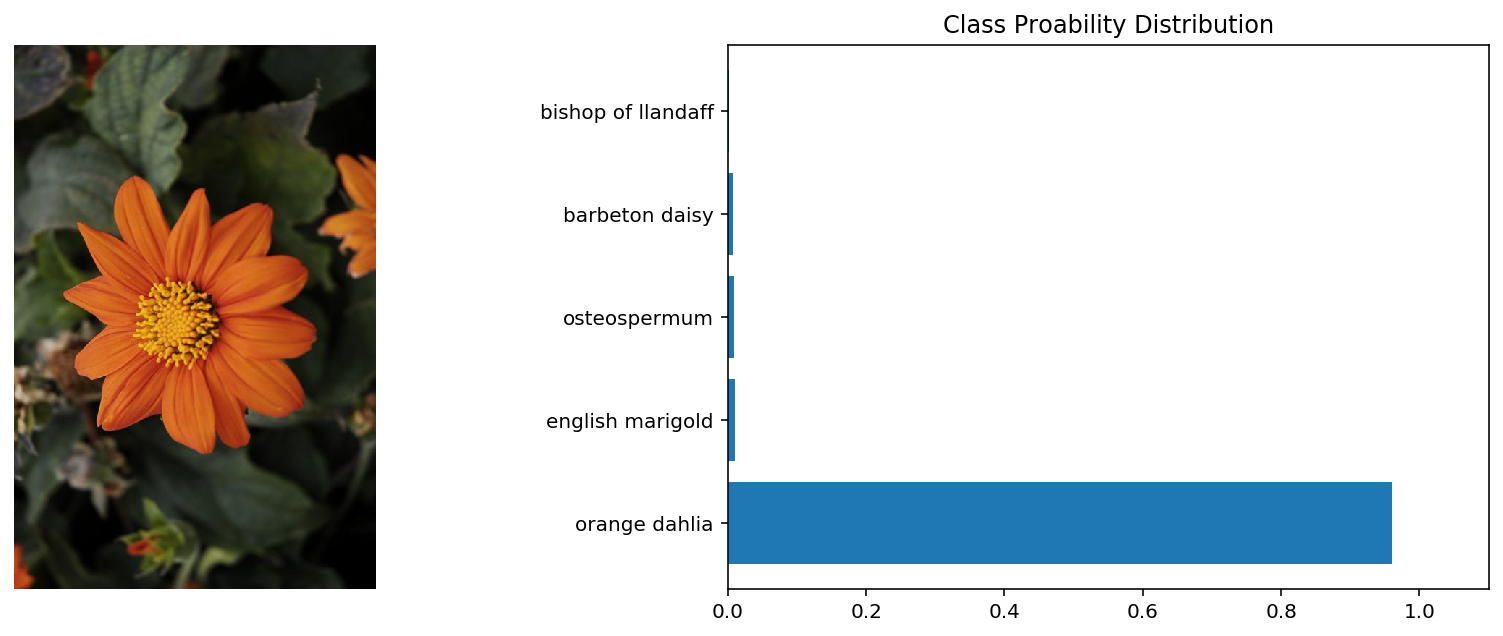

In [44]:
image_path = './test_images/orange_dahlia.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path, 
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

Text(0.5, 1.0, 'Class Proability Distribution')

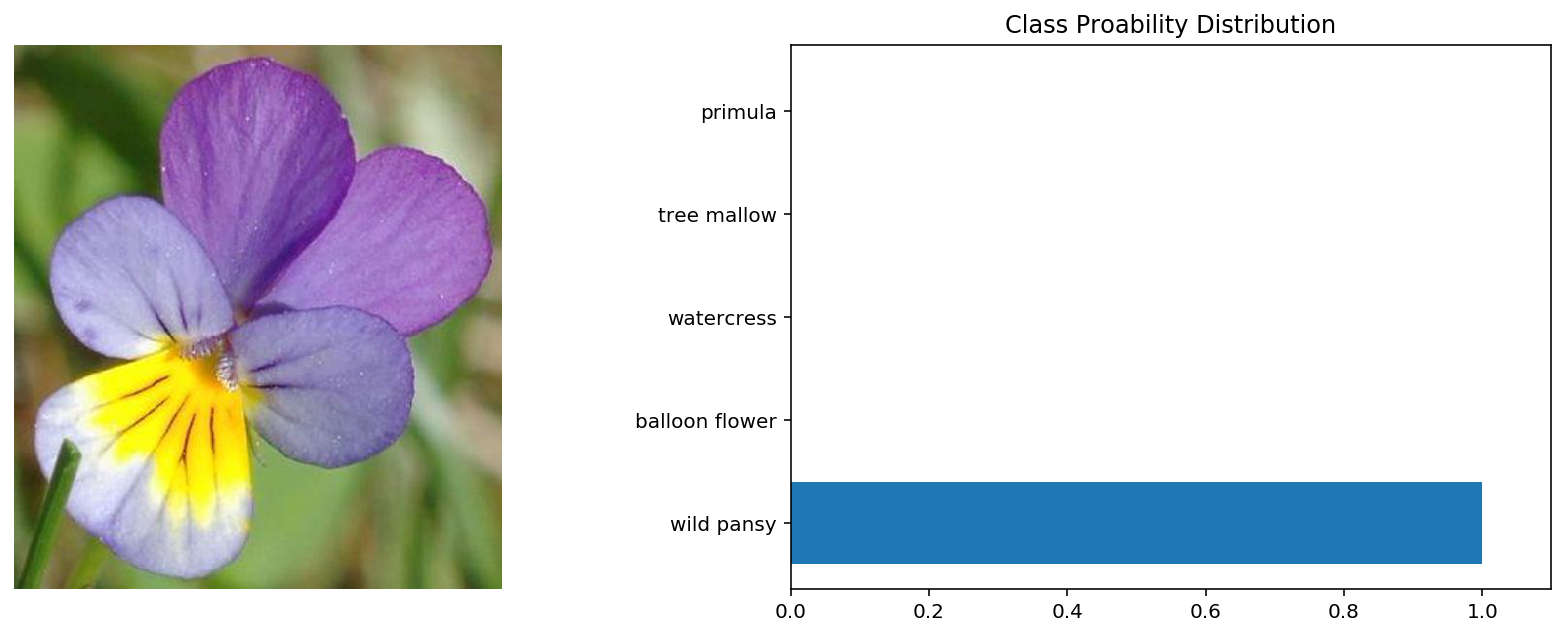

In [45]:
image_path = './test_images/wild_pansy.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path, 
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')

Text(0.5, 1.0, 'Class Proability Distribution')

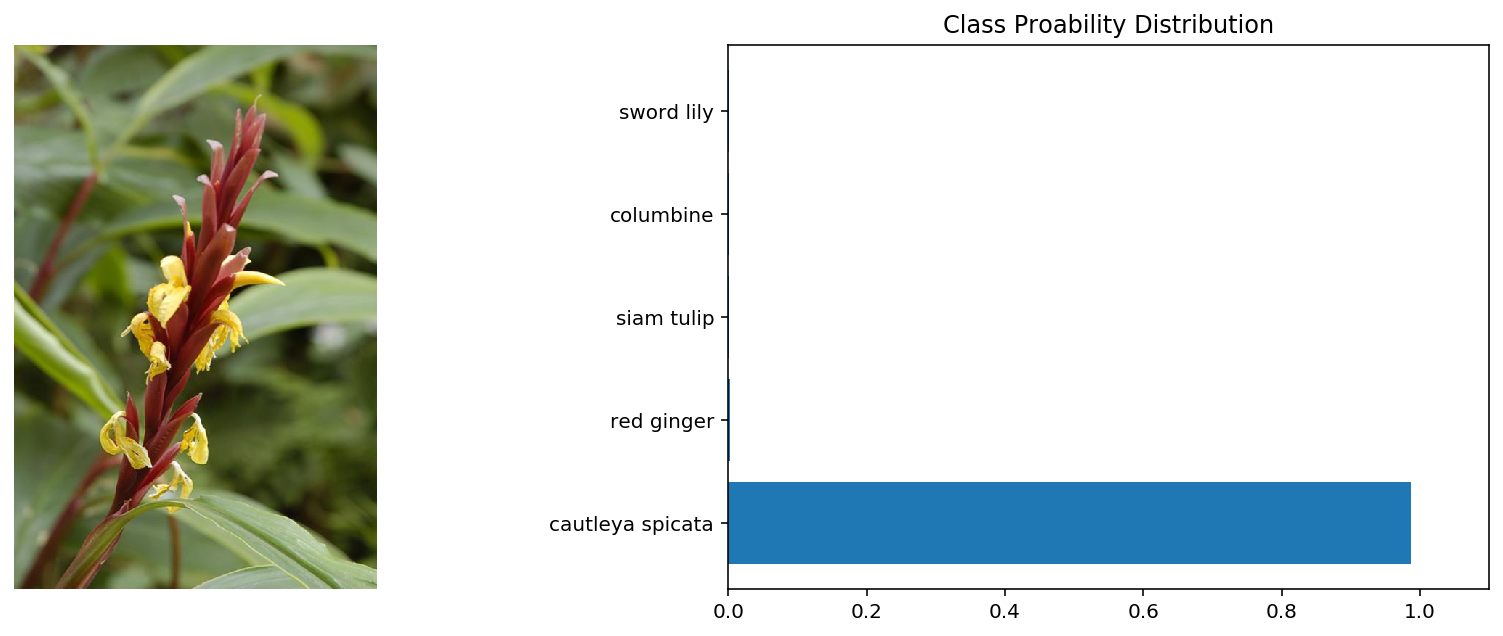

In [46]:
image_path = './test_images/cautleya_spicata.jpg'
img = Image.open(image_path)
img = np.asarray(img)

num_classes = 5

img_probs, img_classes = predict(image_path, 
                                 './Oxford_Flowers102_model_MobileNet.h5',
                                 num_classes)

classes = [class_names[str(img_classes.squeeze()[i] + 1)] for i in range(num_classes)]

fig, (ax1, ax2) = plt.subplots(figsize = (15, 5), ncols = 2)
ax1.imshow(img)
ax1.axis('off')
ax2.barh(np.arange(num_classes), img_probs.squeeze())
ax2.set_xlim(0, 1.1)
ax2.set_yticks(np.arange(num_classes))
ax2.set_yticklabels(classes)
ax2.set_title('Class Proability Distribution')